**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
# Write your code here
import numpy as np
from types import SimpleNamespace
par = SimpleNamespace()
from scipy import optimize
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

In [3]:


# firms
par.A = 1.0
par.gamma = 0.5

# households
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0

# government
par.tau = 0.0
par.T = 0.0

# Question 3
par.kappa = 0.1

In [4]:

# The Consumer
def utility(c1,c2,l,par):
    """ utility of the consumer """
    
    return np.log(c1**par.alpha*c2**(1-par.alpha))-par.nu*l**(1+par.epsilon)/(1+par.epsilon)

def consumer(p1,p2,w,par):
    """ optimal consumer behavior """
    
    # define profits functions
    pi_1_star = ((1-par.gamma)/par.gamma)*w*(p1*par.A*par.gamma/w)**(1/(1-par.gamma))
    pi_2_star = ((1-par.gamma)/par.gamma)*w*(p2*par.A*par.gamma/w)**(1/(1-par.gamma))
    
    # define consumption functions
    def c1(l):
        c_1 = par.alpha*((w*l+par.T+pi_1_star+pi_2_star)/p1)
        return c_1
    
    def c2(l):
        c_2 = (1-par.alpha)*((w*l+par.T+pi_1_star+pi_2_star)/(p2+par.tau))
        return c_2
    
    # solve the maximization problem
    obj = lambda l: -utility(c1(l),c2(l),l,par)
    res = optimize.minimize_scalar(obj)
    
    # save
    l_star = res.x
    c_1_star = c1(l_star)
    c_2_star = c2(l_star)
    
    return l_star,c_1_star,c_2_star

# The Firms
def firms(p1,p2,w,par):
    """ optimal firm behavior """
    
    l_1_star = (p1*par.A*par.gamma/w)**(1/(1-par.gamma))
    l_2_star = (p2*par.A*par.gamma/w)**(1/(1-par.gamma))
    l_star_sum = l_1_star+l_2_star
    y_1_star = par.A*(l_1_star)**par.gamma
    y_2_star = par.A*(l_2_star)**par.gamma
    
    return l_star_sum,y_1_star,y_2_star,


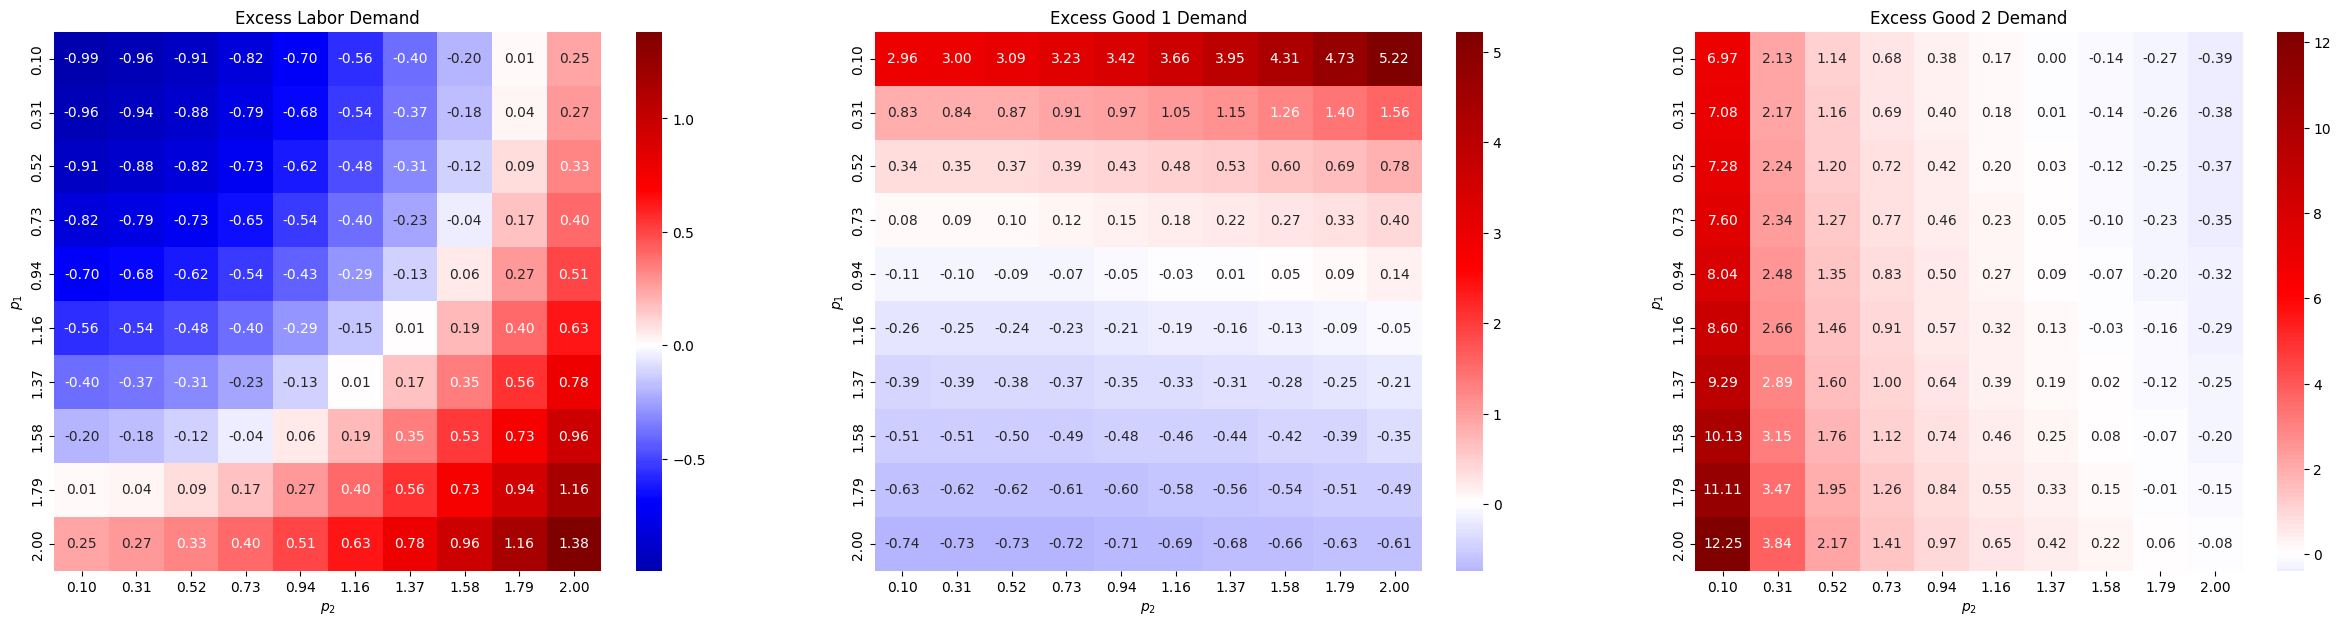

In [5]:
##### Checking Labor Market Clearing #####

# Make DataFrame
p1_values = np.linspace(0.1, 2.0, 10)
p2_values = np.linspace(0.1, 2.0, 10)
eld_table = pd.DataFrame(index=p1_values, columns=p2_values)

# Compute excess labor demand and fill the DataFrame
w = 1
for p1 in p1_values:
    for p2 in p2_values:
        l, c_1, c_2 = consumer(p1, p2, w, par)
        l_f, y_1, y_2 = firms(p1, p2, w, par)
        
        ELD = l_f - l
        eld_table.at[p1, p2] = ELD

# Formatting the DataFrame
eld_table = eld_table.apply(pd.to_numeric)
eld_table.index = eld_table.index.map(lambda x: f"{x:.2f}")
eld_table.columns = eld_table.columns.map(lambda x: f"{x:.2f}")

##### Checking Good Market 1 Clearing #####

# Make DataFrame
p1_values = np.linspace(0.1, 2.0, 10)
p2_values = np.linspace(0.1, 2.0, 10)
egd_1_table = pd.DataFrame(index=p1_values, columns=p2_values)

# Compute excess good 1 demand and fill the DataFrame
w = 1
for p1 in p1_values:
    for p2 in p2_values:
        l, c_1, c_2 = consumer(p1, p2, w, par)
        l_f, y_1, y_2 = firms(p1, p2, w, par)
        
        EGD_1 = c_1 - y_1
        egd_1_table.at[p1, p2] = EGD_1

# Formatting the DataFrame
egd_1_table = egd_1_table.apply(pd.to_numeric)
egd_1_table.index = egd_1_table.index.map(lambda x: f"{x:.2f}")
egd_1_table.columns = egd_1_table.columns.map(lambda x: f"{x:.2f}")

##### Checking Good Market 2 Clearing #####

# Make DataFrame
p1_values = np.linspace(0.1, 2.0, 10)
p2_values = np.linspace(0.1, 2.0, 10)
egd_2_table = pd.DataFrame(index=p1_values, columns=p2_values)

# Compute excess good 2 demand and fill the DataFrame
w = 1
for p1 in p1_values:
    for p2 in p2_values:
        l, c_1, c_2 = consumer(p1, p2, w, par)
        l_f, y_1, y_2 = firms(p1, p2, w, par)
        
        EGD_2 = c_2 - y_2
        egd_2_table.at[p1, p2] = EGD_2

# Formatting the DataFrame
egd_2_table = egd_2_table.apply(pd.to_numeric)
egd_2_table.index = egd_2_table.index.map(lambda x: f"{x:.2f}")
egd_2_table.columns = egd_2_table.columns.map(lambda x: f"{x:.2f}")


# Plotting the heatmaps
plt.figure(figsize=(30, 7))
plt.subplot(1, 3, 1)
sns.heatmap(eld_table, annot=True, fmt=".2f", cmap="seismic", center=0)
plt.title('Excess Labor Demand')
plt.xlabel(r'$p_2$')
plt.ylabel(r'$p_1$')


plt.subplot(1, 3, 2)
sns.heatmap(egd_1_table, annot=True, fmt=".2f", cmap="seismic", center=0)
plt.title('Excess Good 1 Demand')
plt.xlabel(r'$p_2$')
plt.ylabel(r'$p_1$')


plt.subplot(1, 3, 3)
sns.heatmap(egd_2_table, annot=True, fmt=".2f", cmap="seismic", center=0)
plt.title('Excess Good 2 Demand')
plt.xlabel(r'$p_2$')
plt.ylabel(r'$p_1$')
plt.show()

**Market clearing happens where excess demand is 0, i.e. somwhere in the (2 x 2) interval squares where excess demand changes sign (and color from red to blue) in both directions.**

**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

In [6]:
# Finding the Equilibrium Prices

def evaluate_equilibrium(w,par,p1,p2):
    """ evaluate equilirium """
    
    # optimal behavior of the consumer
    l, c_1, c_2 = consumer(p1, p2, w, par)
    
    # optimal behavior of the firms
    l_f, y_1, y_2 = firms(p1, p2, w, par)
 
    # market clearing
    EGD_1 = c_1 - y_1
    EGD_2 = c_2 - y_2
    ELD = l_f - l
    
    return EGD_1,EGD_2,ELD

# Objective function for optimization
def objective(prices, w, par):
    p1, p2 = prices
    EGD_1, EGD_2, ELD = evaluate_equilibrium(w, par, p1, p2)
    
    # aggregate the absolute values of the market clearing conditions
    return np.abs(EGD_1) + np.abs(EGD_2) + np.abs(ELD)

# Initial guess for prices
initial_guess = [1.0, 1.0]

# Optimization
w = 1
result = optimize.minimize(objective, initial_guess, args=(w, par), method='Nelder-Mead')

# Optimal prices
optimal_p1, optimal_p2 = result.x

# Optimal behavior
l_opt, c_1_opt, c_2_opt = consumer(optimal_p1, optimal_p2, w, par)
l_f_opt, y_1_opt, y_2_opt = firms(optimal_p1, optimal_p2, w, par)

# Optimal utility and profit
U_opt = utility(c_1_opt,c_2_opt,l_opt,par)
pi_1_opt = ((1-par.gamma)/par.gamma)*w*(optimal_p1*par.A*par.gamma/w)**(1/(1-par.gamma))
pi_2_opt = ((1-par.gamma)/par.gamma)*w*(optimal_p2*par.A*par.gamma/w)**(1/(1-par.gamma))

print(f'Equilibrium Prices (p_1 , p_2) = ({optimal_p1:.3f} , {optimal_p2:.3f})')
print()
print(f'->     l = {l_opt:.3f}     (l_1 + l_2) = {l_f_opt:.3f}')
print(f'->   y_1 = {y_1_opt:.3f}             c_1 = {c_1_opt:.3f}')
print(f'->   y_2 = {y_2_opt:.3f}             c_2 = {c_2_opt:.3f}')
print()
print(f'->     U = {U_opt:.3f}')
print(f'->  pi_1 = {pi_1_opt:.3f}')
print(f'->  pi_2 = {pi_2_opt:.3f}')

Equilibrium Prices (p_1 , p_2) = (0.976 , 1.491)

->     l = 0.794     (l_1 + l_2) = 0.794
->   y_1 = 0.488             c_1 = 0.488
->   y_2 = 0.745             c_2 = 0.745

->     U = -0.588
->  pi_1 = 0.238
->  pi_2 = 0.556


**The equilibrium prices are $p_1=0.976$ and $p_2=1.491$**

Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

In [7]:
# The Consumer With Taxation
def consumer_tax(p1,p2,w,tau,par):
    """ optimal consumer behavior with taxation """
    
    # define profit functions
    pi_1_star = ((1-par.gamma)/par.gamma)*w*(p1*par.A*par.gamma/w)**(1/(1-par.gamma))
    pi_2_star = ((1-par.gamma)/par.gamma)*w*(p2*par.A*par.gamma/w)**(1/(1-par.gamma))
    
    # define the new consumption functions
    def c1_tax(l):
        c_1 = par.alpha*((w*l+pi_1_star+pi_2_star)/p1*(p2+tau)/(p2+par.alpha*tau))
        return c_1
    
    def c2_tax(l):
        c_2 = (1-par.alpha)*((w*l+pi_1_star+pi_2_star)/(p2+par.alpha*tau))
        return c_2
    
    # solve the utility maximization problem
    obj = lambda l: -utility(c1_tax(l),c2_tax(l),l,par)
    res = optimize.minimize_scalar(obj)
    
    # save
    l_star = res.x
    c_1_star = c1_tax(l_star)
    c_2_star = c2_tax(l_star)
    
    return l_star,c_1_star,c_2_star

# Check with equilibrium prices and tau = 0
l_opt_tax, c1_opt_tax, c2_opt_tax = consumer_tax(optimal_p1,optimal_p2,1,0,par)
print(f'Check With Equilibrium Prices (p_1 , p_2) = ({optimal_p1:.3f} , {optimal_p2:.3f}) and tau = 0')
print(f'->  l = {l_opt_tax:.3f}, c_1 = {c1_opt_tax:.3f}, c_2 = {c2_opt_tax:.3f}')

Check With Equilibrium Prices (p_1 , p_2) = (0.976 , 1.491) and tau = 0
->  l = 0.794, c_1 = 0.488, c_2 = 0.745


In [8]:
# The Government
def government(p1,p2,w,par):
    """ optimal government behavior """
    
    # define social welfare function
    def SWF(tau):
        l_star, c_1_star, c_2_star = consumer_tax(p1,p2,w,tau,par)
        SWF = utility(c_1_star,c_2_star,l_star,par) - par.kappa*c_2_star
        return SWF
    
    # solve the SW maximization problem
    obj = lambda tau: -SWF(tau)
    res = optimize.minimize_scalar(obj)
    
    # save
    tau_star = res.x
    T_star = tau_star
    
    return tau_star

In [9]:
# Finding the Equilibrium Prices, Tau and Implied T
def evaluate_equilibrium_tax(w,par,p1,p2):
    """ evaluate equilirium """
    
    # optimal government behavior
    tau = government(p1, p2, w, par)
    
    # optimal behavior of the consumer
    l, c_1, c_2 = consumer_tax(p1, p2, w, tau, par)
    
    # optimal behavior of the firms (unaffected by tau)
    l_f, y_1, y_2 = firms(p1, p2, w, par)
 
    # market clearing
    EGD_1 = c_1 - y_1
    EGD_2 = c_2 - y_2
    ELD = l_f - l
    
    return EGD_1,EGD_2,ELD

# Objective function for optimization
def objective_tax(prices, w, par):
    p1, p2 = prices
    EGD_1, EGD_2, ELD = evaluate_equilibrium_tax(w, par, p1, p2)
    
    # Aggregate the absolute values of the market clearing conditions
    return np.abs(EGD_1) + np.abs(EGD_2) + np.abs(ELD)

# Initial guess for prices
initial_guess_tax = [1.0, 1.0]

# Optimization
w = 1
result_tax = optimize.minimize(objective_tax, initial_guess_tax, args=(w, par), method='Nelder-Mead')

# Optimal prices
optimal_p1_tax, optimal_p2_tax = result_tax.x

# Optimal behavior
tau_opt = government(optimal_p1_tax, optimal_p2_tax, w, par)
l_opt_tax, c_1_opt_tax, c_2_opt_tax = consumer_tax(optimal_p1_tax, optimal_p2_tax, w,tau_opt, par)
l_f_opt_tax, y_1_opt_tax, y_2_opt_tax = firms(optimal_p1_tax, optimal_p2_tax, w, par)

# Social welfare in optimum
SWF_opt = utility(c_1_opt_tax,c_2_opt_tax,l_opt_tax,par) - par.kappa*c_2_opt_tax

print(f'Equilibrium Prices (p_1 , p_2) = ({optimal_p1_tax:.3f} , {optimal_p2_tax:.3f})')
print()
print(f'->     l = {l_opt_tax:.3f}     (l_1 + l_2) = {l_f_opt_tax:.3f}')
print(f'->   y_1 = {y_1_opt_tax:.3f}             c_1 = {c_1_opt_tax:.3f}')
print(f'->   y_2 = {y_2_opt_tax:.3f}             c_2 = {c_2_opt_tax:.3f}')
print()
print(f'->   tau = {tau_opt:.3f}')
print(f'->     T = {tau_opt*y_2_opt_tax:.3f}')
print(f'->   SWF = {SWF_opt:.3f}')

Equilibrium Prices (p_1 , p_2) = (1.000 , 1.000)

C:\Users\patry\AppData\Local\Temp\ipykernel_44296\1133004214.py:5: RuntimeWarning: invalid value encountered in scalar power
  return np.log(c1**par.alpha*c2**(1-par.alpha))-par.nu*l**(1+par.epsilon)/(1+par.epsilon)




->     l = nan     (l_1 + l_2) = 0.500
->   y_1 = 0.500             c_1 = nan
->   y_2 = 0.500             c_2 = nan

->   tau = nan
->     T = nan
->   SWF = nan


**The government should thus choose $\tau=0.171$ and $T=0.125$ to maximize $SWF$ in equilibrium.**

## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

In [10]:
par = SimpleNamespace()
par.J = 3
par.N = 10
par.K = 10000

par.F = np.arange(1,par.N+1)
par.sigma = 2

par.v = np.array([1,2,3])
par.c = 1

**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


In [11]:

# Stating the parameters
par.J = 3  # Number of career choices
par.N = 10  # Number of graduates
par.K = 10000  # Number of simulations

par.F = np.arange(1, par.N + 1)  # Array of friends count
par.sigma = 2  # Standard deviation of the noise term
par.v = np.array([1, 2, 3])  # Utility values for each career choice
par.c = 1  # Switching cost

# Simulating the utility values
utilities = np.zeros((par.K, par.J))  # Initialising utility matrix

# Generating utilities for each career choice across K simulations
for j in range(par.J):
    epsilon = np.random.normal(0, par.sigma, par.K)  # Noise term
    utilities[:, j] = par.v[j] + epsilon  # Utility calculation

# Calculating the expected utility for each career choice
expected_utilities = np.mean(utilities, axis=0)

# Calculating the average realised utility
average_realised_utilities = np.mean(utilities, axis=0)

# Results
print("Expected Utilities: ", expected_utilities)
print("Average Realised Utilities: ", average_realised_utilities)


Expected Utilities:  [0.95042698 1.98748873 3.02087654]
Average Realised Utilities:  [0.95042698 1.98748873 3.02087654]


Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

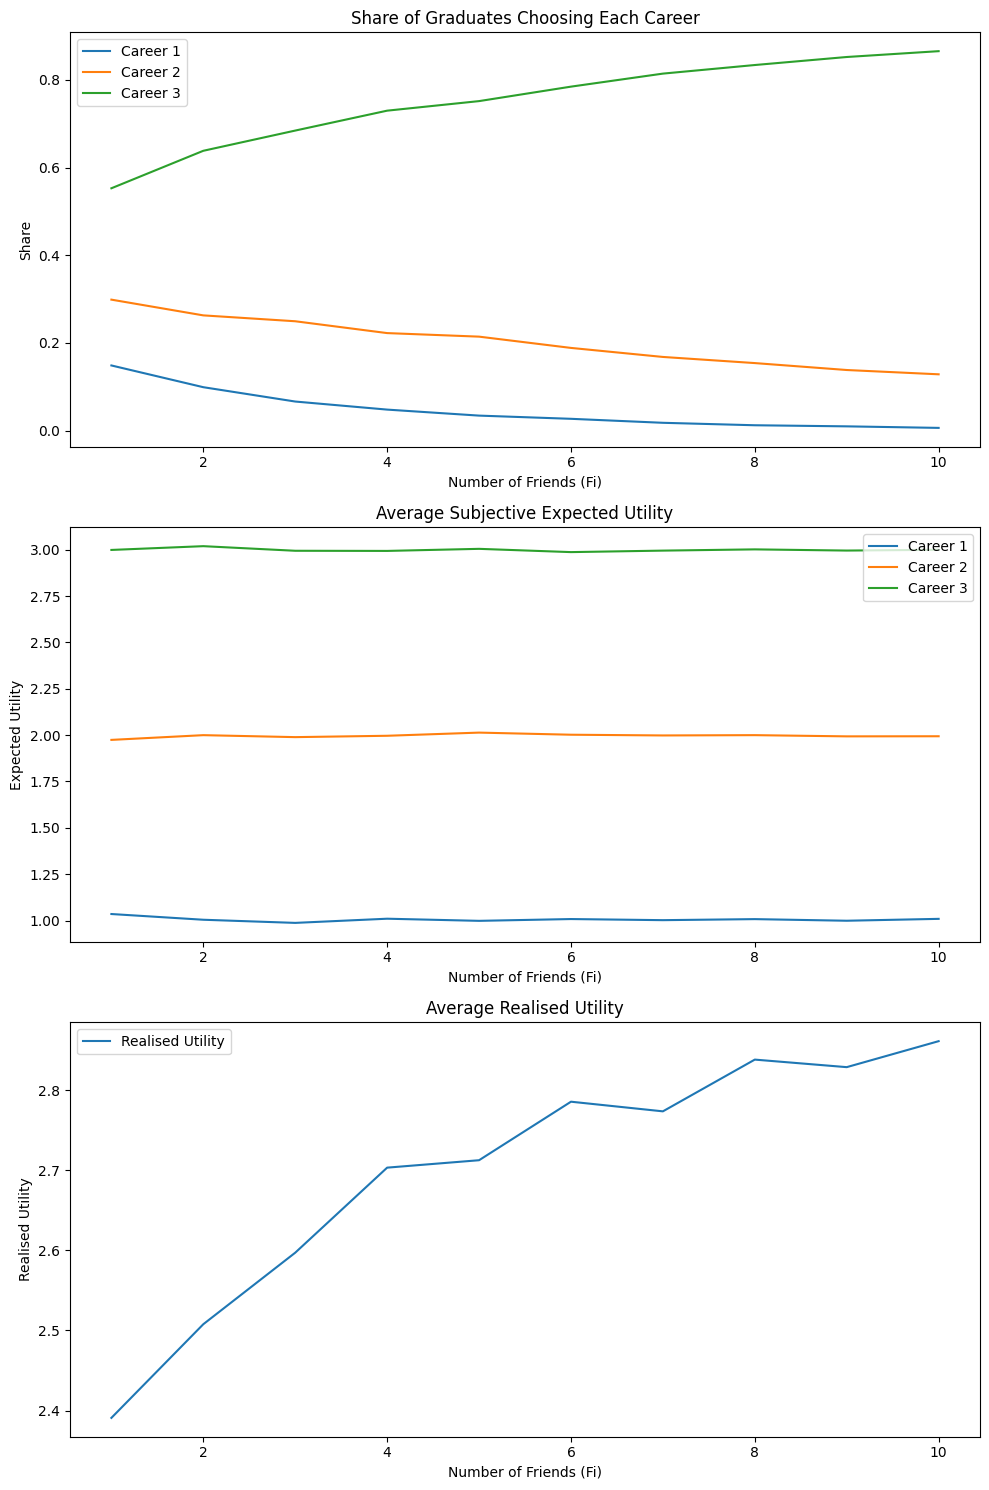

In [12]:

# Initialising storage for results
chosen_careers = np.zeros((par.N, par.K), dtype=int)  # Chosen career for each graduate
prior_expectations = np.zeros((par.N, par.K, par.J))  # Prior expected utilities
realised_utilities = np.zeros((par.N, par.K))  # Realised utilities

# Simulation for each graduate
for i in range(par.N):
    Fi = i + 1  # Number of friends for the current graduate
    for k in range(par.K):
        # Simulate friends' utilities
        friends_utilities = np.zeros((Fi, par.J))
        for f in range(Fi):
            epsilon_f = np.random.normal(0, par.sigma, par.J)  # Noise term for friends
            friends_utilities[f, :] = par.v + epsilon_f  # Friends' utilities
        
        # Calculating prior expected utility
        prior_expectation = np.mean(friends_utilities, axis=0)
        prior_expectations[i, k, :] = prior_expectation
        
        # Drawing own noise terms
        epsilon_k = np.random.normal(0, par.sigma, par.J)  # Noise term for the graduate
        own_utilities = par.v + epsilon_k  # Graduate's utilities
        
        # Choosing the career with highest expected utility
        chosen_career = np.argmax(prior_expectation)
        chosen_careers[i, k] = chosen_career
        realised_utilities[i, k] = own_utilities[chosen_career]

# Calculating share of graduates choosing each career
career_shares = np.zeros((par.N, par.J))
for i in range(par.N):
    for j in range(par.J):
        career_shares[i, j] = np.mean(chosen_careers[i, :] == j)

# Calculating average subjective expected utility and realised utility
avg_expected_utilities = np.mean(prior_expectations, axis=1)
avg_realised_utilities = np.mean(realised_utilities, axis=1)

# Visualising the results
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plotting share of graduates choosing each career
for j in range(par.J):
    axs[0].plot(par.F, career_shares[:, j], label=f'Career {j+1}')
axs[0].set_title('Share of Graduates Choosing Each Career')
axs[0].set_xlabel('Number of Friends (Fi)')
axs[0].set_ylabel('Share')
axs[0].legend()

# Plotting average subjective expected utility
for j in range(par.J):
    axs[1].plot(par.F, avg_expected_utilities[:, j], label=f'Career {j+1}')
axs[1].set_title('Average Subjective Expected Utility')
axs[1].set_xlabel('Number of Friends (Fi)')
axs[1].set_ylabel('Expected Utility')
axs[1].legend()

# Plotting average realised utility
axs[2].plot(par.F, avg_realised_utilities, label='Realised Utility')
axs[2].set_title('Average Realised Utility')
axs[2].set_xlabel('Number of Friends (Fi)')
axs[2].set_ylabel('Realised Utility')
axs[2].legend()

plt.tight_layout()
plt.show()


After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

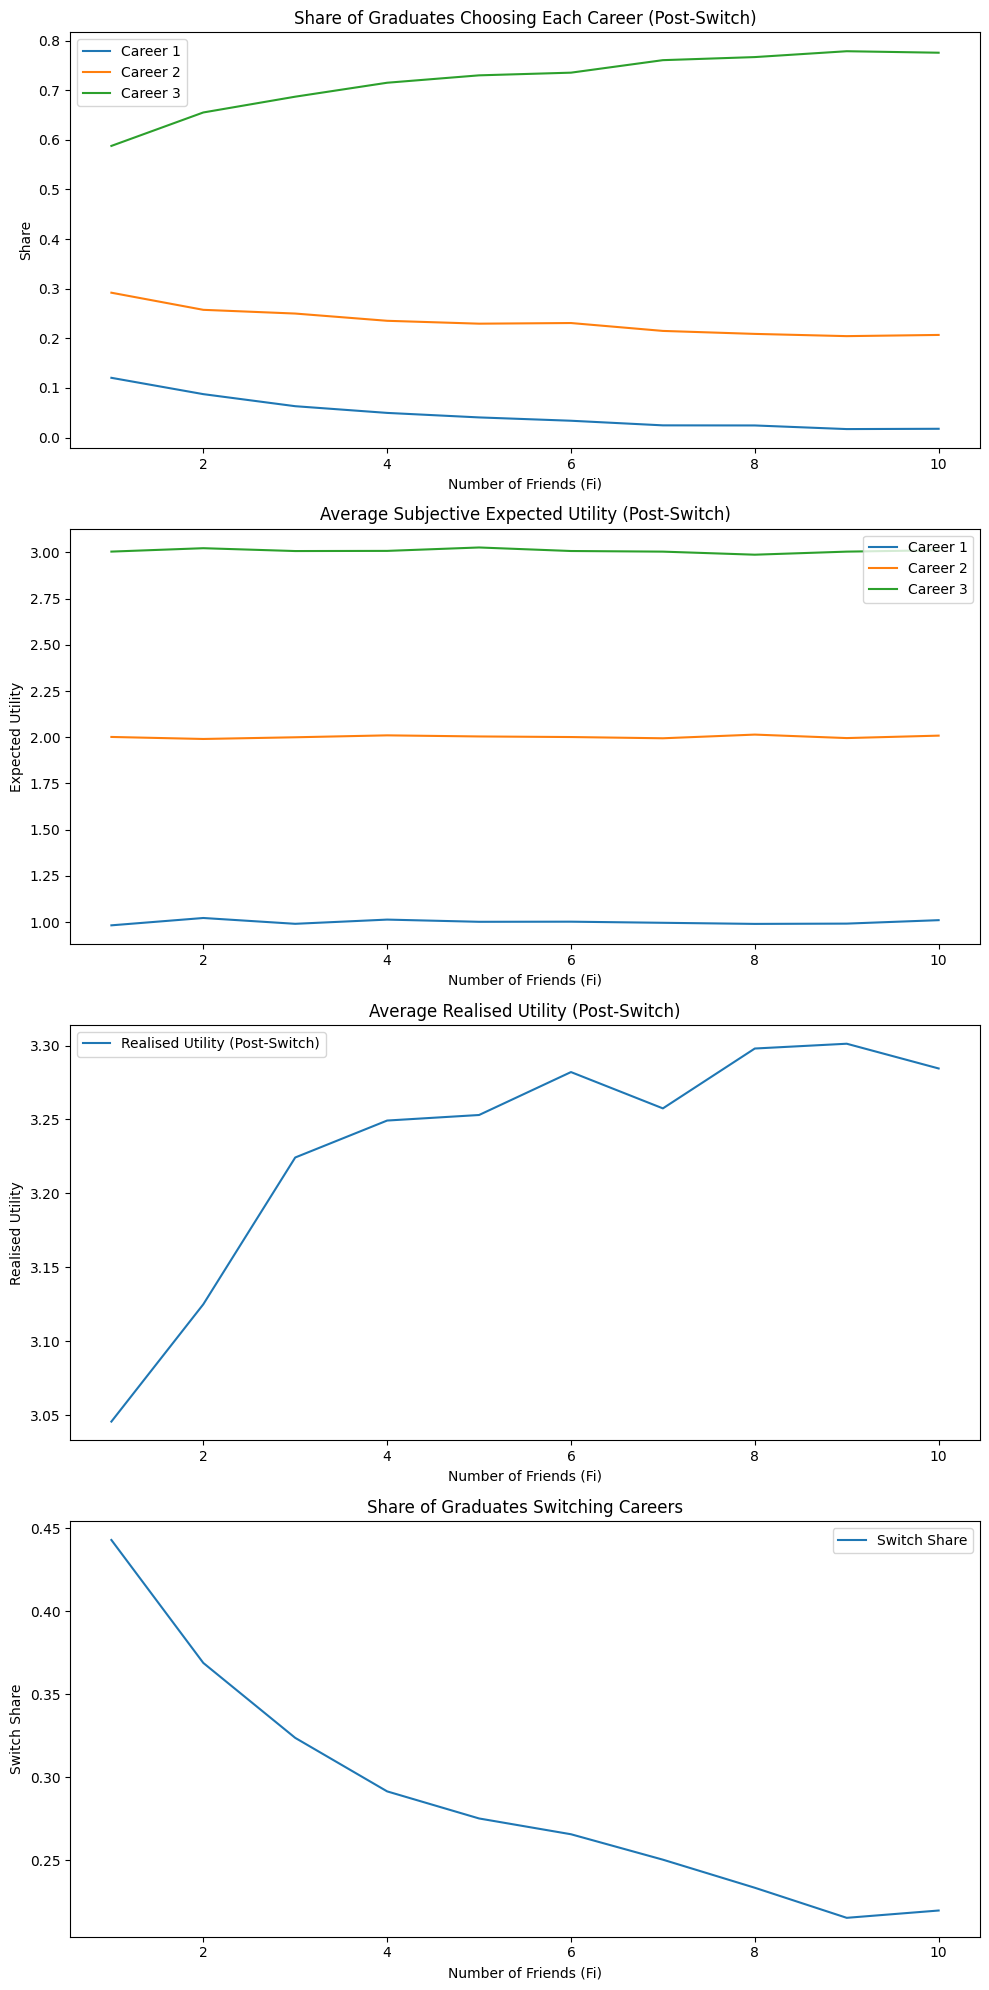

In [13]:
# Stating the parameters for switching cost scenario
c = 1  # Switching cost
new_prior_expectations = np.zeros((par.N, par.K, par.J))  # New prior expected utilities
new_chosen_careers = np.zeros((par.N, par.K), dtype=int)  # New chosen careers
new_realised_utilities = np.zeros((par.N, par.K))  # New realised utilities

# Simulation for each graduate
for i in range(par.N):
    Fi = i + 1  # Number of friends for the current graduate
    for k in range(par.K):
        # Simulating friends' utilities
        friends_utilities = np.zeros((Fi, par.J))
        for f in range(Fi):
            epsilon_f = np.random.normal(0, par.sigma, par.J)  # Noise term for friends
            friends_utilities[f, :] = par.v + epsilon_f  # Friends' utilities
        
        # Calculating prior expected utility
        prior_expectation = np.mean(friends_utilities, axis=0)
        new_prior_expectations[i, k, :] = prior_expectation
        
        # Drawing own noise terms for remaining two careers
        epsilon_k = np.random.normal(0, par.sigma, par.J)  # Noise term for the graduate
        own_utilities = par.v + epsilon_k  # Graduate's utilities
        
        # Calculating utility with the switching cost
        current_career = chosen_careers[i, k]  # Previously chosen career
        switch_utilities = np.copy(prior_expectation)
        switch_utilities[current_career] = own_utilities[current_career]  # Keep current career utility
        for j in range(par.J):
            if j != current_career:
                switch_utilities[j] -= c  # Apply switching cost
        
        # Choosing new career with highest utility
        new_career = np.argmax(switch_utilities)
        new_chosen_careers[i, k] = new_career
        new_realised_utilities[i, k] = own_utilities[new_career]

# Calculating share of graduates choosing each career
new_career_shares = np.zeros((par.N, par.J))
for i in range(par.N):
    for j in range(par.J):
        new_career_shares[i, j] = np.mean(new_chosen_careers[i, :] == j)

# Calculating average subjective expected utility and realised utility
new_avg_expected_utilities = np.mean(new_prior_expectations, axis=1)
new_avg_realised_utilities = np.mean(new_realised_utilities, axis=1)

# Calculating the share of graduates that switch careers
switch_shares = np.zeros(par.N)
for i in range(par.N):
    switch_shares[i] = np.mean(new_chosen_careers[i, :] != chosen_careers[i, :])

# Visualising the results
fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# Plotting share of graduates choosing each career (Post-Switch)
for j in range(par.J):
    axs[0].plot(par.F, new_career_shares[:, j], label=f'Career {j+1}')
axs[0].set_title('Share of Graduates Choosing Each Career (Post-Switch)')
axs[0].set_xlabel('Number of Friends (Fi)')
axs[0].set_ylabel('Share')
axs[0].legend()

# Plotting the average subjective expected utility (Post-Switch)
for j in range(par.J):
    axs[1].plot(par.F, new_avg_expected_utilities[:, j], label=f'Career {j+1}')
axs[1].set_title('Average Subjective Expected Utility (Post-Switch)')
axs[1].set_xlabel('Number of Friends (Fi)')
axs[1].set_ylabel('Expected Utility')
axs[1].legend()

# Plotting the average realised utility (Post-Switch)
axs[2].plot(par.F, new_avg_realised_utilities, label='Realised Utility (Post-Switch)')
axs[2].set_title('Average Realised Utility (Post-Switch)')
axs[2].set_xlabel('Number of Friends (Fi)')
axs[2].set_ylabel('Realised Utility')
axs[2].legend()

# Plotting the share of graduates switching careers
axs[3].plot(par.F, switch_shares, label='Switch Share')
axs[3].set_title('Share of Graduates Switching Careers')
axs[3].set_xlabel('Number of Friends (Fi)')
axs[3].set_ylabel('Switch Share')
axs[3].legend()

plt.tight_layout()
plt.show()


## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [14]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))


**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.

Point y: [0.20901926 0.37774759]
Point A: [0.26071605 0.43635845]
Point B: [0.21315735 0.274245  ]
Point C: [0.10056103 0.27951775]
Point D: [0.20634391 0.44272557]


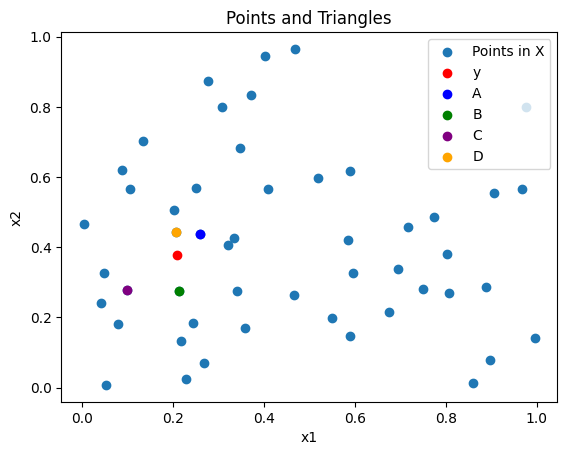

In [15]:
# Function to find the points A, B, C, D
def find_points(X, y):
    # Initialize distances with a large value
    dist_A = np.inf
    dist_B = np.inf
    dist_C = np.inf
    dist_D = np.inf
    
    A, B, C, D = None, None, None, None
    
    for point in X:
        dist = np.linalg.norm(point - y)
        
        if point[0] > y[0] and point[1] > y[1] and dist < dist_A:
            A = point
            dist_A = dist
        
        if point[0] > y[0] and point[1] < y[1] and dist < dist_B:
            B = point
            dist_B = dist
        
        if point[0] < y[0] and point[1] < y[1] and dist < dist_C:
            C = point
            dist_C = dist
        
        if point[0] < y[0] and point[1] > y[1] and dist < dist_D:
            D = point
            dist_D = dist
    
    return A, B, C, D

A, B, C, D = find_points(X, y)

# Print the points for debugging
print(f'Point y: {y}')
print(f'Point A: {A}')
print(f'Point B: {B}')
print(f'Point C: {C}')
print(f'Point D: {D}')

# Plotting the points
plt.scatter(X[:,0], X[:,1], label='Points in X')
plt.scatter(y[0], y[1], color='red', label='y')
if A is not None:
    plt.scatter(A[0], A[1], color='blue', label='A')
if B is not None:
    plt.scatter(B[0], B[1], color='green', label='B')
if C is not None:
    plt.scatter(C[0], C[1], color='purple', label='C')
if D is not None:
    plt.scatter(D[0], D[1], color='orange', label='D')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Points and Triangles')
plt.show()



**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

In [16]:
# write your answer here

# Function to calculate barycentric coordinates
def barycentric_coordinates(x, A, B, C):
    denominator = (B[1] - C[1]) * (A[0] - C[0]) + (C[0] - B[0]) * (A[1] - C[1])
    r1 = ((B[1] - C[1]) * (x[0] - C[0]) + (C[0] - B[0]) * (x[1] - C[1])) / denominator
    r2 = ((C[1] - A[1]) * (x[0] - C[0]) + (A[0] - C[0]) * (x[1] - C[1])) / denominator
    r3 = 1 - r1 - r2
    return r1, r2, r3

# Compute barycentric coordinates for y with respect to ABC and CDA

def compute_interpolation(y, A, B, C, D):
    if any(pt is None for pt in [A, B, C, D]):
        return np.nan

    rABC1, rABC2, rABC3 = barycentric_coordinates(y, A, B, C)
    rCDA1, rCDA2, rCDA3 = barycentric_coordinates(y, C, D, A)

    # Check if y is inside the triangle ABC
    if all(0 <= r <= 1 for r in [rABC1, rABC2, rABC3] if r is not None):
        return rABC1 * f(A) + rABC2 * f(B) + rABC3 * f(C)
    # Check if y is inside the triangle CDA
    elif all(0 <= r <= 1 for r in [rCDA1, rCDA2, rCDA3] if r is not None):
        return rCDA1 * f(C) + rCDA2 * f(D) + rCDA3 * f(A)
    else:
        return np.nan

Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [17]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

In [18]:
# Compute the approximation of f(y)
def interpolate_value(y, A, B, C, D, F, X):
    rABC1, rABC2, rABC3 = barycentric_coordinates(y, A, B, C)
    rCDA1, rCDA2, rCDA3 = barycentric_coordinates(y, C, D, A)
    
    if all(0 <= r <= 1 for r in [rABC1, rABC2, rABC3] if r is not None):
        return rABC1 * f(A) + rABC2 * f(B) + rABC3 * f(C)
    elif all(0 <= r <= 1 for r in [rCDA1, rCDA2, rCDA3] if r is not None):
        return rCDA1 * f(C) + rCDA2 * f(D) + rCDA3 * f(A)
    else:
        return np.nan

f_y_approx = interpolate_value(y, A, B, C, D, F, X)
f_y_true = f(y)

print(f'Approximate value of f(y): {f_y_approx}')
print(f'True value of f(y): {f_y_true}')



Approximate value of f(y): 0.08405201731052576
True value of f(y): 0.0789565216259594


**Question 4:** Repeat question 3 for all points in the set $Y$.

In [19]:
Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.8,0.2),(0.5,0.5)]

In [20]:
Y = np.array(Y)

# Compute the interpolated and true values for all points in Y
results = []
for y in Y:
    A, B, C, D = find_points(X, y)

    '''
    # Print the points for debugging
    print(f'For point y={y}:')
    print(f'Point A: {A}')
    print(f'Point B: {B}')
    print(f'Point C: {C}')
    print(f'Point D: {D}')
    '''

    f_y_approx = compute_interpolation(y, A, B, C, D)
    f_y_true = f(y)
    results.append((y, f_y_approx, f_y_true))

df_results = pd.DataFrame(results, columns=['y', 'f_y_approx', 'f_y_true'])
print(df_results)

# Explanation of the NaN value:
# The NaN value for the point [0.8, 0.8] in the example is due to the absence
# of a point in the 50-element set X that satisfies the triangels ABC,CDA seraching algorithm condition x[1] > 0.8 and x[2] > 0.8.
# Increasing the number of points in X would help to ensure that appropriate points can be found but such improvemnts are not required in the exam questions

            y  f_y_approx  f_y_true
0  [0.2, 0.2]    0.040326      0.04
1  [0.8, 0.2]    0.158742      0.16
2  [0.8, 0.8]         NaN      0.64
3  [0.8, 0.2]    0.158742      0.16
4  [0.5, 0.5]    0.251290      0.25
